In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

## UpSet plot of tool overlap by novelty category

In [7]:
# UMA
mt_df = pd.read_csv('../data/05_mastertable/master_table.tsv', sep='\t')
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
print(len(mt_df.loc[mt_df.pop_spec_t==True, 'isoform'].unique()))

5447


In [8]:
c_dict, order = get_novelty_colors()
tool_cols = ['espresso', 'flair', 'isoquant', 'lyric']
mt_df = mt_df[tool_cols+['structural_category']]
for t in tool_cols:
    mt_df[t] = mt_df[t].astype(bool)

m = {'espresso':'ESPRESSO',
     'flair':'FLAIR',
     'isoquant':'IsoQuant',
     'lyric':'LyRic'}
mt_df.rename(m, axis=1, inplace=True)
mt_df.head()
mt_df.set_index([item for key, item in m.items()], inplace=True)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


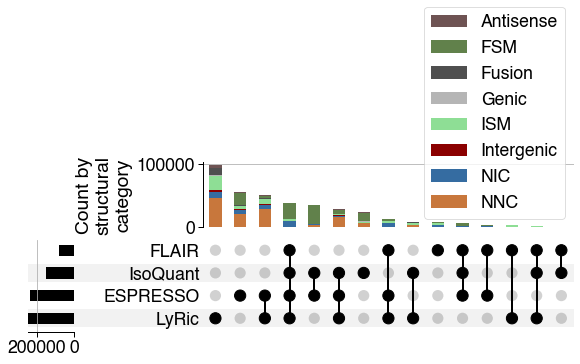

In [9]:
init_plot_settings(font_scale=1.2)
upset = upsetplot.UpSet(mt_df, intersection_plot_elements=0, sort_by='cardinality')  # disable the default bar chart
upset.add_stacked_bars(
    by='structural_category',
    colors=c_dict,
    title='Count by\nstructural\ncategory')
upset.plot()
plt.savefig('transcript_detection_tool_structural_category_upset.pdf', 
            dpi=500)

## UpSet plots showing filter complementarity
`filter_overlap_upset.ipynb`


In [10]:
mt_df = pd.read_csv('../data/05_mastertable/master_table_filtering.tsv', sep='\t')
mt_df.rename({'Recount3 Support': 'Recount3'}, axis=1, inplace=True)

# remove fsm and ism
temp = mt_df.loc[~(mt_df.structural_category.isin(['FSM', 'ISM']))]

# rm stuff not filtered out
temp = temp.loc[temp.filter_sharing>0]

temp['rm_more_one'] = temp.filter_sharing>1
temp[['Tool', 'rm_more_one']].groupby('rm_more_one').count()

,Tool
rm_more_one,
False,42984
True,135592


In [11]:
# what % of transcripts are remoed by more than one?
135592/(135592+42984)

0.759295762028492

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "sep" which is no longer supported as of 3.3 and will become an error in 3.6
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


53706
36268
126986
105884


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


7960
7229


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


30110
27866


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


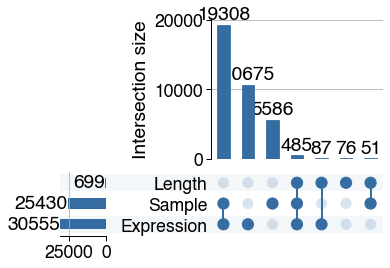

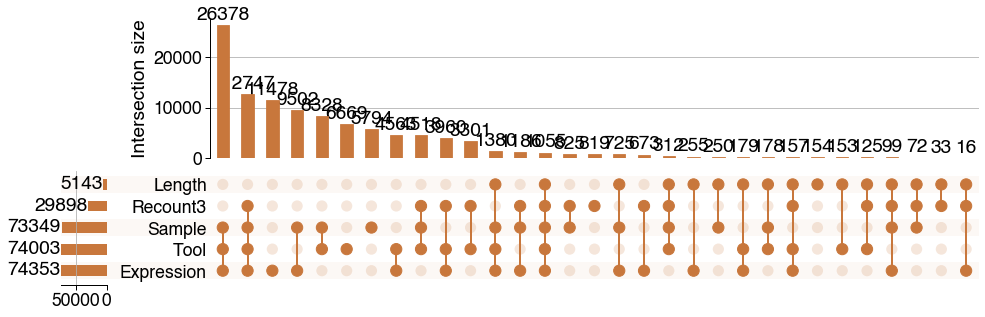

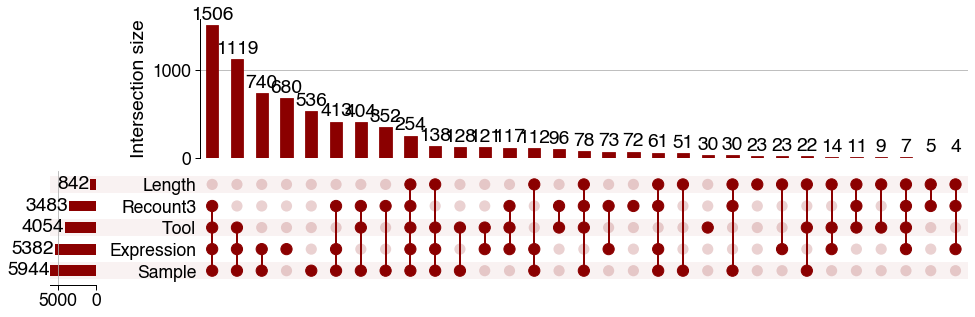

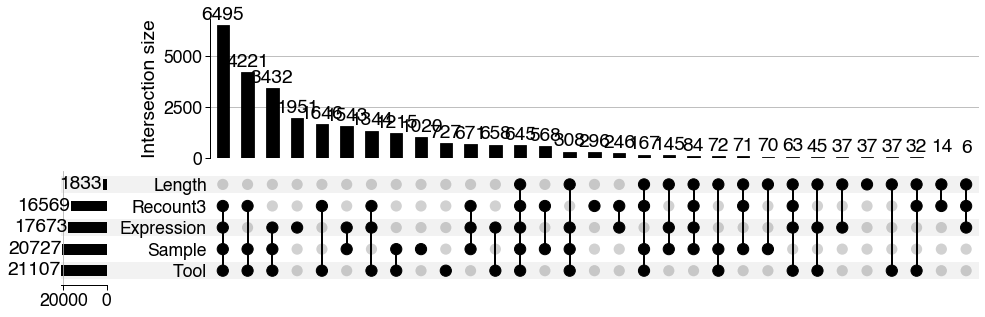

In [12]:
things = ['Length', 'Recount3', 'Sample', 'Tool', 'Expression']
m = {'NIC': ['Length', 'Sample', 'Expression'],
     'NNC': things,
     'Intergenic': things, 
     'Genic': things,
     'Antisense': things,
     'Fusion': things}
groups = [['NIC'],
          ['NNC'],
          ['Intergenic'],
          ['Antisense', 'Fusion', 'Genic']]

c_dict, order = get_novelty_colors()
for g in groups:
    temp = mt_df.loc[mt_df.structural_category.isin(g)].copy(deep=True)
    temp = temp[m[g[0]]]
    
    # remove those passing filters
    print(len(temp.index))
    temp = temp.loc[temp[m[g[0]]].sum(axis=1)>0]
    print(len(temp.index))

    for c in m[g[0]]:
        temp[c] = temp[c].astype(bool)
    temp['isoform'] = [i for i in range(len(temp.index))]
    temp.set_index(m[g[0]], inplace=True)

    init_plot_settings(font_scale=1.2)
    color = c_dict[g[0]]
    if len(g) > 1:
        color = 'k'
    upset = upsetplot.UpSet(temp, sort_by='cardinality', show_counts=True, #show_counts=True,
                            facecolor=color)  # disable the default bar chart
    upset.plot()
    plt.savefig(f'{g[0]}_filter_sharing.pdf', sep=500, layout='tight')

## Inter-catalog overlap UpSet plot
`../figure_characterize_poder/compare_annotation_to_external.ipynb`

In [14]:
df = pd.DataFrame()
ics = [proc_cfg(config['gtex']['cerb']['ics'], od),
       proc_cfg(config['chess']['cerb']['ics'], od),
       proc_cfg(config['enc']['cerb']['ics'], od),
       proc_cfg(config['lr']['cerb']['ics'], od),
       proc_cfg(config['ref']['cerb']['ics'], od),
       proc_cfg(config['ref']['refseq']['cerb']['ics'], od)]
sources = ['GTEx', 'CHESS3', 'ENCODE4', 'PODER', 'GENCODE v47', 'RefSeq v110']
for ic, source in zip(ics, sources):
    temp = pd.read_csv(ic, sep='\t')
    
    # remove monoexonic, add source, drop name
    temp = temp.loc[temp.Coordinates != '-']
    temp['source'] = source
    temp = temp.drop('Name', axis=1)
    
    df = pd.concat([df, temp], axis=0)    

In [15]:
temp = df.copy(deep=True)
df = df.pivot_table(
    index=['Strand', 'Coordinates', 'Chromosome'],
    columns='source',
    aggfunc=lambda x: True,
    fill_value=False).reset_index()
df.reset_index(drop=True, inplace=True)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


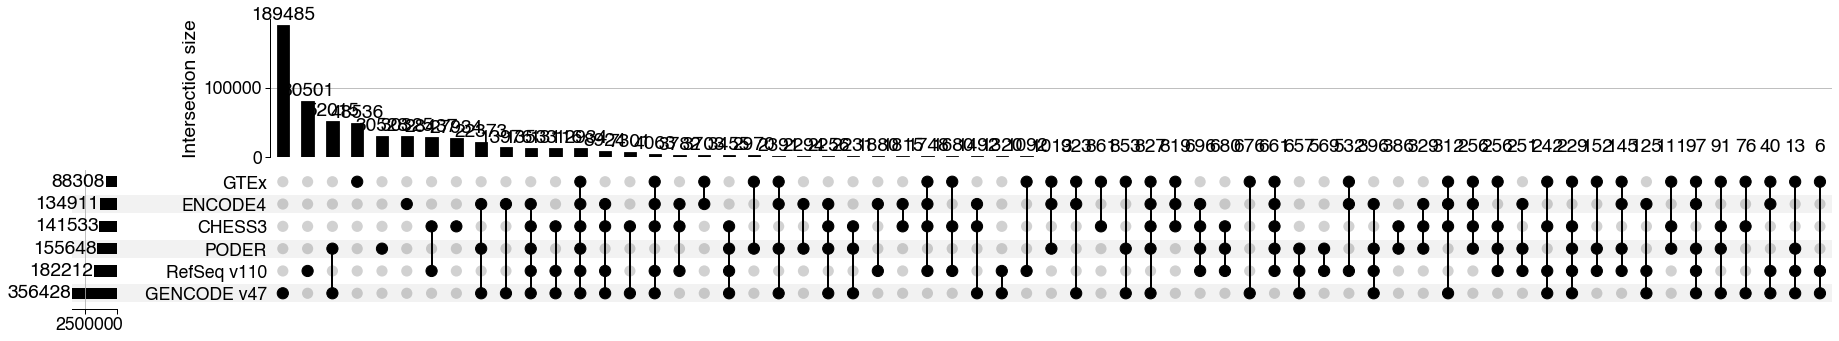

In [16]:
# full plot
temp = df[sources+['Strand']].groupby(sources).count().reset_index()
temp.rename({'Strand':'n_ic'}, axis=1, inplace=True)
temp.head()
df = df.merge(temp[sources+['n_ic']], 
              how='left',
              on=sources)
df.set_index(sources, inplace=True)
init_plot_settings(font_scale=1)
upsetplot.plot(df, sort_by='cardinality', show_counts=True)
plt.savefig('annot_overlap_upset.pdf', dpi=500)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


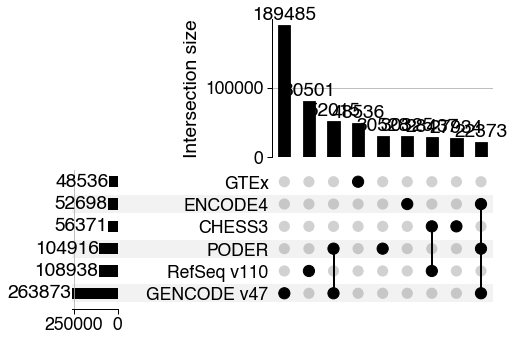

In [17]:
# limited to just top n intersections

# remove entries that are past a certain number
temp = df.loc[df.n_ic >= 21000].copy(deep=True)
init_plot_settings(font_scale=1)
upsetplot.plot(temp, sort_by='cardinality', show_counts=True)
plt.savefig('annot_overlap_upset_short.pdf', dpi=500)

## Tables used to plot other results in this section

In [22]:
# PODER transcripts' statuses in external catalogs

# get ic <-> tid
df = pd.DataFrame()
gtfs = [proc_cfg(config['lr']['gtf_filt_with_genes'], od)]
sources = ['PODER']

for f, s in zip(gtfs, sources):
    temp = pr.read_gtf(f)
    temp = cerberus.get_ic(temp)
    temp['source'] = s
    df = pd.concat([df, temp], axis=0)
    
ics_df = df.copy(deep=True)    
ics_df['ic_id'] = ics_df.Chromosome.astype(str)+'_'+\
                  ics_df.Strand.astype(str)+'_'+\
                  ics_df.ic.astype(str)

df = pd.DataFrame()
ics = [proc_cfg(config['gtex']['cerb']['ics'], od),
       proc_cfg(config['chess']['cerb']['ics'], od),
       proc_cfg(config['enc']['cerb']['ics'], od),
       proc_cfg(config['lr']['cerb']['ics'], od),
       proc_cfg(config['ref']['cerb']['ics'], od),
       proc_cfg(config['ref']['refseq']['cerb']['ics'], od)]
sources = ['GTEx', 'CHESS3', 'ENCODE4', 'PODER', 'GENCODE v47', 'RefSeq v110']
for ic, source in zip(ics, sources):
    temp = pd.read_csv(ic, sep='\t')
    
    # remove monoexonic, add source, drop name
    temp = temp.loc[temp.Coordinates != '-']
    temp['source'] = source
    temp = temp.drop('Name', axis=1)
    
    df = pd.concat([df, temp], axis=0)    
temp = df.copy(deep=True)
df = df.pivot_table(
    index=['Strand', 'Coordinates', 'Chromosome'],
    columns='source',
    aggfunc=lambda x: True,
    fill_value=False).reset_index()
df.reset_index(drop=True, inplace=True)

# limit to poder = true 
df = df.loc[df.PODER==True]

# add ic id w/ chrom and strand
df['ic_id'] = df.Chromosome.astype(str)+'_'+\
              df.Strand.astype(str)+'_'+\
              df.Coordinates.astype(str)

df = df.merge(ics_df[['transcript_id', 'ic_id']],
              how='left', 
              on='ic_id')

assert len(df.loc[df.transcript_id.isnull()]) ==0
df.to_csv('241121_poder_transcripts_by_external_support.tsv', sep='\t')

In [24]:
# external catalog support of PODER transcripts by novelty category

gtf_file = proc_cfg(config['lr']['gtf_filt_with_genes'], od)
gtf_df = pr.read_gtf(gtf_file, duplicate_attr=True)
gtf_df = cerberus.get_ic(gtf_df)
gtf_df.rename({'ic':'Coordinates'}, axis=1, inplace=True)

df = df.merge(gtf_df.drop('gene_id', axis=1),
              how='left',
              on=['Chromosome', 'Coordinates', 'Strand'])
assert len(df.loc[df.transcript_id.isnull()]) == 0

# get novelty cats from the mt
mt_df = pd.read_csv('../../data/05_mastertable/poder_master_table.tsv', sep='\t')
df = df.merge(mt_df[['structural_category', 'isoform']],
              how='left',
              left_on='transcript_id',
              right_on='isoform')

df['supported_by_external'] = (df[['GTEx', 'CHESS3', 'ENCODE4']].sum(axis=1))>0
temp = df[['transcript_id', 'structural_category', 'supported_by_external']].groupby(['structural_category', 'supported_by_external']).count().reset_index().rename({'transcript_id':'n_t'},axis=1)
temp.to_csv('241031_n_supported_ics_by_novelty.tsv', sep='\t')

AttributeError: 'DataFrame' object has no attribute 'transcript_id'